In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.layers import Input, Conv2D, UpSampling2D


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


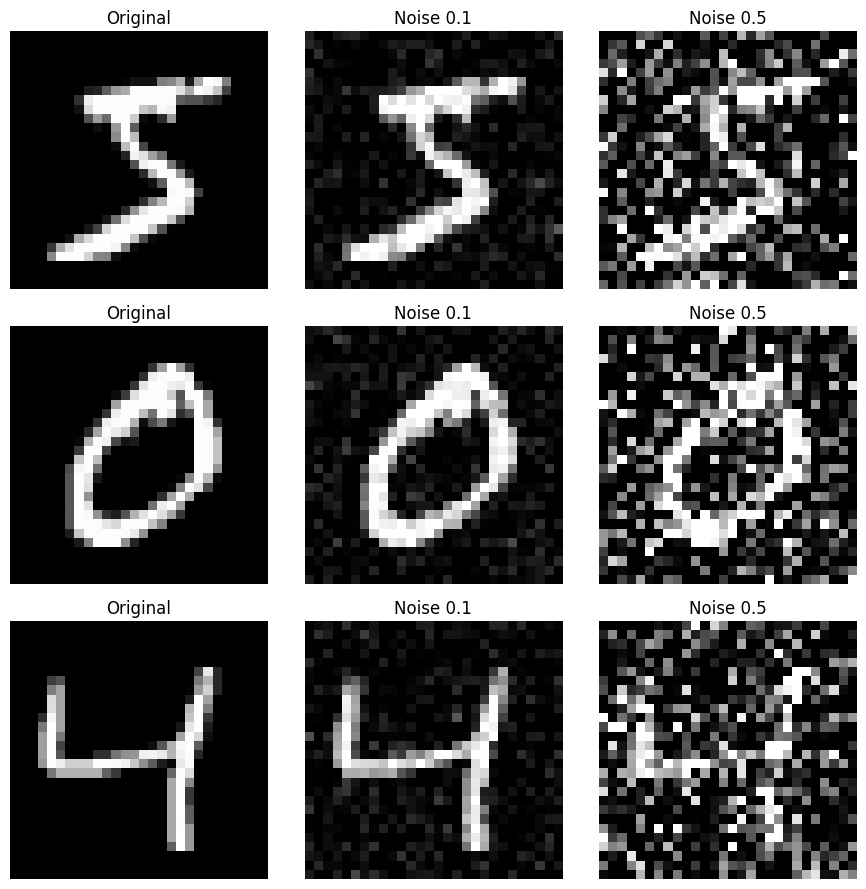

In [ ]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5

x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))

for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [ ]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [ ]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.2438 - val_loss: 0.1125
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1116 - val_loss: 0.1052
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1047 - val_loss: 0.1012
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1018 - val_loss: 0.0996
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1000 - val_loss: 0.0995
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0990 - val_loss: 0.0975
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0979 - val_loss: 0.0966
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0971 - val_loss: 0.0959
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0964 - val_loss: 0.0956
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0958 - val_loss: 0.0955


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


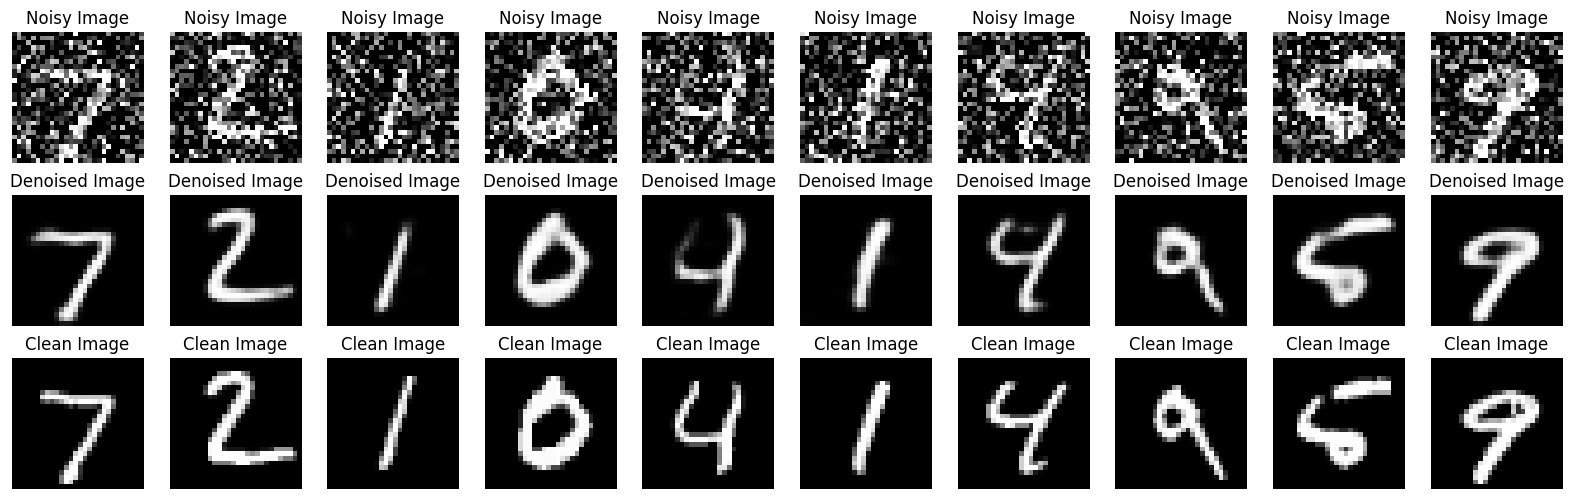

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
  plt.figure(figsize=(20, 6))
  for i in range(n):
    # Plot noisy images
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy Image")
    plt.axis('off')
    # Plot denoised images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised Image")
    plt.axis('off')
    # Plot clean images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
    plt.title("Clean Image")
    plt.axis('off')
  plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

## Dev Nagari

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

dataset_path = "/content/drive/MyDrive/devnagari digit.zip"
extract_path = "/content/"
# Extract the zip file
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['.config', 'drive', 'DevanagariHandwrittenDigitDataset', 'sample_data']

In [ ]:
train_dir = "/content/DevanagariHandwrittenDigitDataset/Train"

In [ ]:
import os

# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 10 classes: ['digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']


In [ ]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path

# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


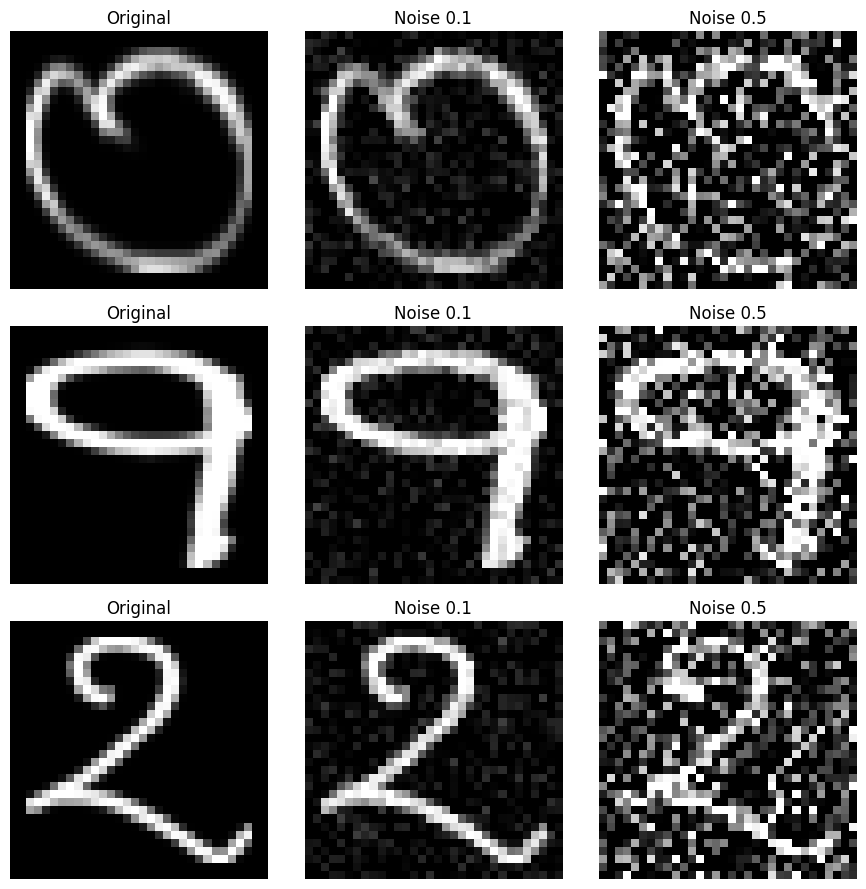

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load dataset
train_dir = "/content/DevanagariHandwrittenDigitDataset/Train"
class_names = sorted(os.listdir(train_dir))

# Load all images
all_images = []
for cls in class_names:
    class_path = os.path.join(train_dir, cls)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert('L')
        img = img.resize((32, 32))
        img = np.array(img).astype('float32') / 255.0
        all_images.append(img)

all_images = np.array(all_images)
all_images = np.reshape(all_images, (len(all_images), 32, 32, 1))

# Add noise to all data
noise_factor = 0.5
all_images_noisy = all_images + noise_factor * np.random.normal(0.0, 1.0, all_images.shape)
all_images_noisy = np.clip(all_images_noisy, 0., 1.)

# Split dataset
x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    all_images, all_images_noisy, test_size=0.2, random_state=42
)

# ===============================
# VISUALIZE SAMPLE IMAGES WITH NOISE
# ===============================
samples = []
for cls in class_names[:3]:  # Pick 3 classes
    class_path = os.path.join(train_dir, cls)
    image_files = os.listdir(class_path)
    img_path = os.path.join(class_path, random.choice(image_files))
    img = Image.open(img_path).convert('L')
    img = img.resize((32, 32))
    img = np.array(img).astype('float32') / 255.0
    samples.append(img)

samples = np.array(samples)
samples = np.reshape(samples, (len(samples), 32, 32, 1))

noise_factor_low = 0.1
noise_factor_high = 0.5
noisy_low = samples + noise_factor_low * np.random.normal(0.0, 1.0, samples.shape)
noisy_high = samples + noise_factor_high * np.random.normal(0.0, 1.0, samples.shape)
noisy_low = np.clip(noisy_low, 0., 1.)
noisy_high = np.clip(noisy_high, 0., 1.)

plt.figure(figsize=(9, 9))
for i in range(3):
    ax = plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(samples[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(noisy_low[i].reshape(32, 32), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    ax = plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(noisy_high[i].reshape(32, 32), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_encoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape, name="input")

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)      # Layer 1
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)              # Layer 2
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)             # Layer 3
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)         # Bottleneck

    return input_img, encoded

def build_decoder(encoded_input):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input) # Layer 4
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)              # Layer 5
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)              # Layer 6
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x) # Output layer

    return decoded

def build_autoencoder(input_shape=(32, 32, 1)):
    input_img, encoded_output = build_encoder(input_shape)
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

# Build and show the model
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.4986 - val_loss: 0.2520
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2348 - val_loss: 0.2046
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1978 - val_loss: 0.1853
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1819 - val_loss: 0.1757
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1726 - val_loss: 0.1704
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1671 - val_loss: 0.1665
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1625 - val_loss: 0.1619
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1595 - val_loss: 0.1599
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1572 - val_loss: 0.1611
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1550 - val_loss: 0.1565
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1531 - val_loss: 0.1556
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━

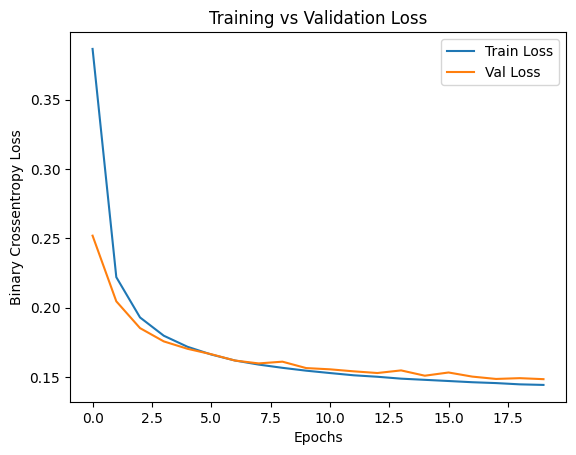

In [ ]:
# ===============================
# PLOT LOSS CURVES
# ===============================
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


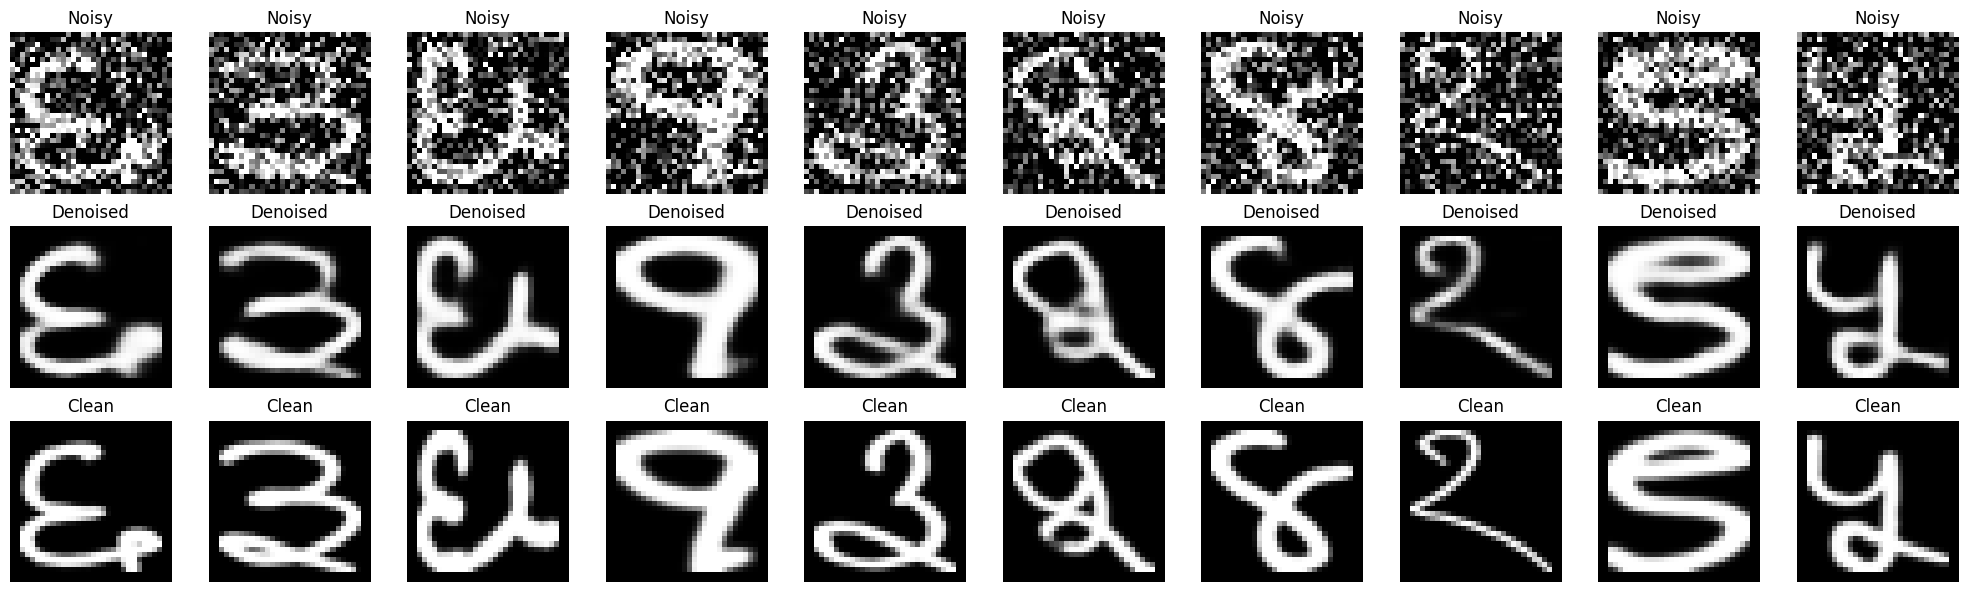

In [ ]:
# Predict denoised images from the noisy test images
denoised_images = autoencoder.predict(x_test_noisy)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(32, 32), cmap='gray')
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first 10 test samples
plot_images(x_test_noisy, denoised_images, x_test, n=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def denoise_single_image(img_path_or_url, model, from_url=False):
    """
    Loads a single image, adds noise if needed, denoises it using the model, and displays result.

    Args:
    - img_path_or_url: str, path or URL to the image
    - model: trained autoencoder model
    - from_url: bool, set True if passing URL
    """

    # Load image
    if from_url:
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path_or_url)

    # Preprocess: grayscale, resize, normalize
    img = img.convert('L')
    img = img.resize((32, 32))
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape(1, 32, 32, 1)

    # Predict
    denoised = model.predict(img_array)

    # Show both
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_array[0].reshape(32, 32), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised[0].reshape(32, 32), cmap='gray')
    plt.title("Denoised Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


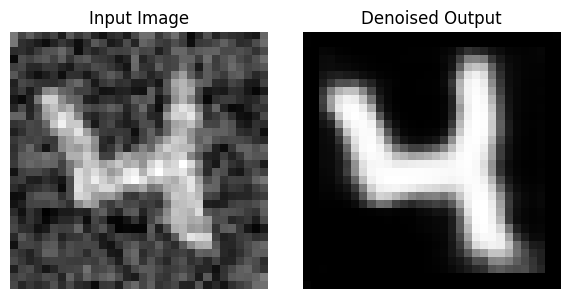

In [ ]:
denoise_single_image("/content/Image 17-04-2025 at 08.28.jpeg", autoencoder)